In [40]:
import pysam
import numpy as np
import scipy.stats
import pandas as pd
import seaborn as sns
import os.path
import matplotlib.pyplot as plt
sns.set(font_scale=2)
sns.set_style("white")
%matplotlib inline
from IPython.core.pylabtools import figsize


#### Load excel file

In [3]:
chum_taqman_excelfile = os.path.join('data', 'TaqMan', 'chumRAD_TaqMan.xlsx')
chum_taqman = pd.read_excel(chum_taqman_excelfile, header = None)
chum_taqman.columns = ['seqID', 'seq']
chum_taqman = chum_taqman.set_index('seqID')
chum_taqman.head()

seq
seqID                                                          
Oke_RAD10940  TGCAGGTTAAGAAGCTGGATGTGGTGGTTCTGGGCTGGCATGGTTA...
Oke_RAD10719  TGCAGGTCAACTGAGGTAAACAGCCACCTYGATGAATAGAGCGAGA...
Oke_RAD10676  TGCAGGAAAATTCACAATTACAATAGAGCTTGTGTAGTTCAGGAAA...
Oke_RAD10605  TGCAGGCACCTGGTCCGCCACAATGAGTCACTAGAGTGCAATGAGC...
Oke_RAD10227  TGCAGGAAGGGTACCACGAGGGGGGAGAATRTCTTAATTATAATGC...

In [33]:
len(chum_taqman)

129

#### Histogram of sequence lengths

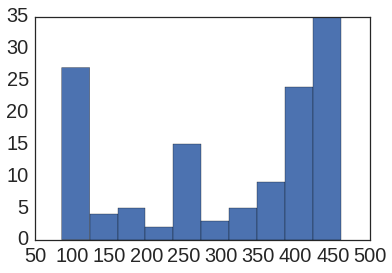

In [10]:
plt.hist([len(x) for x in chum_taqman['seq']], bins = 10)
plt.show()

#### Write fasta file

In [11]:
chum_taqman_fastafile = os.path.join('data', 'TaqMan', 'chumRAD_TaqMan.fasta')
with open(chum_taqman_fastafile, 'w') as OUTFILE:
    for entry in chum_taqman.itertuples():
        OUTFILE.write('>{}\n{}\n'.format(*entry))

#### Build bowtie index

In [29]:
bowtie_index = os.path.join('data','TaqMan','chumTaqMan')
!{'bowtie2-build {} {}'.format(chum_taqman_fastafile, bowtie_index)}

Settings:
  Output files: "data/TaqMan/chumTaqMan.*.bt2"
  Line rate: 6 (line is 64 bytes)
  Lines per side: 1 (side is 64 bytes)
  Offset rate: 4 (one in 16)
  FTable chars: 10
  Strings: unpacked
  Max bucket size: default
  Max bucket size, sqrt multiplier: default
  Max bucket size, len divisor: 4
  Difference-cover sample period: 1024
  Endianness: little
  Actual local endianness: little
  Sanity checking: disabled
  Assertions: disabled
  Random seed: 0
  Sizeofs: void*:8, int:4, long:8, size_t:8
Input files DNA, FASTA:
  data/TaqMan/chumRAD_TaqMan.fasta
Building a SMALL index
Reading reference sizes
  Time reading reference sizes: 00:00:00
Calculating joined length
Writing header
Reserving space for joined string
Joining reference sequences
  Time to join reference sequences: 00:00:00
bmax according to bmaxDivN setting: 9711
Using parameters --bmax 7284 --dcv 1024
  Doing ahead-of-time memory usage test
  Passed!  Constructing with these parameters: --bmax 7284 --dcv 1024
Const

#### Align curated chum reference 

In [31]:
chum_ref = '/media/Shared/Data/chum/populations/ref/paper_1/chum_paper_1_ref.CURATED.fasta'

In [20]:
SAM_output = os.path.join('data', 'TaqMan', 'chumRAD_TaqMan.sam')

In [32]:
!bowtie2 -f --local --very-sensitive -p 4 -x {bowtie_index} -U {chum_ref} -S {SAM_output}

88282 reads; of these:
  88282 (100.00%) were unpaired; of these:
    86083 (97.51%) aligned 0 times
    1859 (2.11%) aligned exactly 1 time
    340 (0.39%) aligned >1 times
2.49% overall alignment rate


## Examine SAM file

In [35]:
# this function uses pysam to iterate over alignments in the SAM file
def get_aligns():
    return(pysam.AlignmentFile(SAM_output, "r").fetch())

## Mapping quality (MAPQ)

In [36]:
mpqs = [read.mapping_quality for read in get_aligns()]

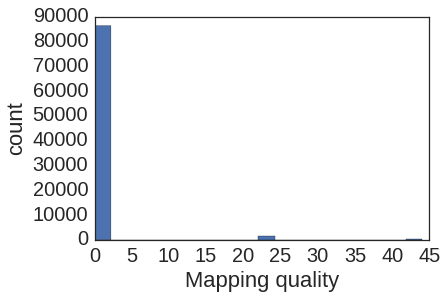

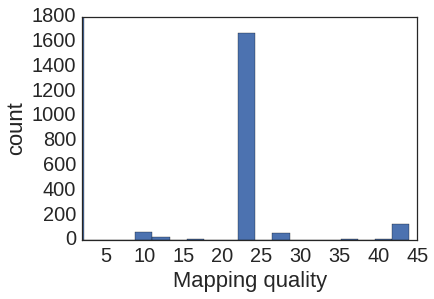

In [53]:
figsize(6, 4)
plt.hist(mpqs, bins = 20)
plt.xlabel('Mapping quality')
plt.ylabel('count')
plt.title('')
plt.show()

plt.hist(mpqs, bins = 20)
plt.xlabel('Mapping quality')
plt.ylabel('count')
plt.title('')
plt.xlim(2)
plt.ylim(0, 1800)
plt.show()

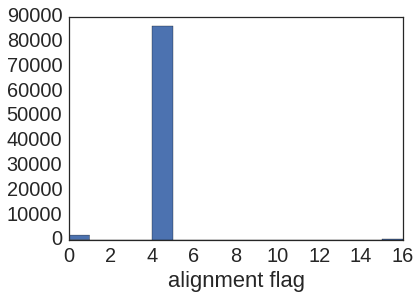

In [54]:
#### Strand bias
flags  = [read.flag for read in get_aligns()]
plt.hist(flags, bins = 16)
plt.xlabel('alignment flag')
plt.show()

#### Alignment length

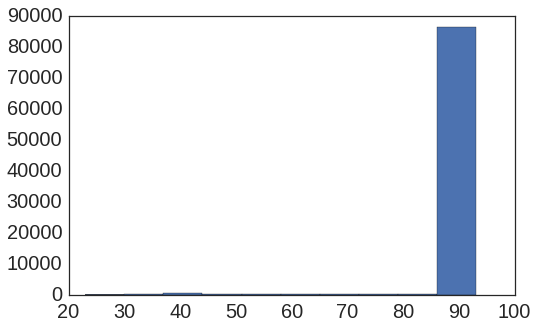

In [46]:
figsize(8, 5)
qal =  [read.query_alignment_length for read in get_aligns()]
plt.hist(qal)
plt.xlabel('Aligned length')
plt.show()

#### Edit distacnce

In [48]:
edit_distances = list()
mq = list()
for read in get_aligns():
    try:
        edit_distances.append(np.int(read.get_tag('XM')))
        mq.append(np.int(read.mapping_quality))
    except KeyError:
        pass

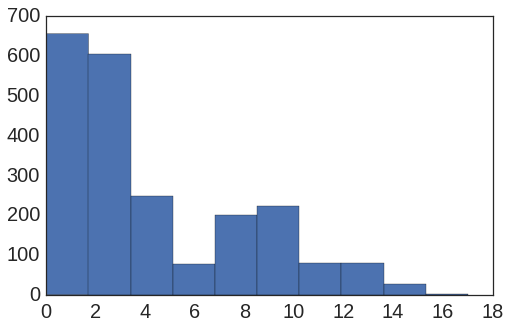

In [49]:
plt.hist(edit_distances)
plt.xlabel('edit distance')
plt.show()

## Filter SAM file

#### Lets keep only the alignments with:
(query_alignment_length >= 90) AND (mapping_quality >= 30)

In [196]:
filtered_SAM_output = os.path.join('data', 'TaqMan', 'chumRAD_TaqMan.filtered.sam')

In [197]:
with pysam.AlignmentFile(SAM_output, "r") as INFILE:
    with pysam.AlignmentFile(filtered_SAM_output, "wh", template=INFILE) as OUTFILE:
        for aln in INFILE:
            if (aln.query_alignment_length >= 90) and (aln.mapping_quality >= 30):
                OUTFILE.write(aln)

In [198]:
def get_filtered_aligns():
    return(pysam.AlignmentFile(filtered_SAM_output, "r").fetch())
len([read.qname for read in get_filtered_aligns()])

103

In [199]:
by_mapq = pd.DataFrame([(read.qname, pysam.AlignmentFile(filtered_SAM_output, "r").references[read.rname]) for read in get_filtered_aligns()])
by_mapq.columns = ['ref', 'TaqManID']

In [208]:
len(set(by_mapq['ref']))

103

In [209]:
len(set(by_mapq['TaqManID']))

103

In [207]:
by_mapq.to_csv(os.path.join('data','TaqMan', 'matches_by_mapq.txt'), index = False, sep = '\t')

## By edit distance

In [200]:
with pysam.AlignmentFile(SAM_output, "r") as INFILE:
    with pysam.AlignmentFile(filtered_SAM_output, "wh", template=INFILE) as OUTFILE:
        for aln in INFILE:
            try:
                edit_distance = (np.int(aln.get_tag('XM')))
            except KeyError:
                edit_distance = 10
            
            if (aln.query_alignment_length >= 90) and edit_distance <= 4:
                OUTFILE.write(aln)

In [201]:
def get_filtered_aligns():
    return(pysam.AlignmentFile(filtered_SAM_output, "r").fetch())
len([read.qname for read in get_filtered_aligns()])

102

In [202]:
by_edit_distance = pd.DataFrame([(read.qname, pysam.AlignmentFile(filtered_SAM_output, "r").references[read.rname]) for read in get_filtered_aligns()])
by_edit_distance.columns = ['ref', 'TaqManID']

In [204]:
pd.merge(by_mapq, by_edit_distance, left_on='ref', right_on='ref', how= 'outer').tail(170)

ref    TaqManID_x    TaqManID_y
0      c628  Oke_RAD17085  Oke_RAD17085
1      c799   Oke_RAD4286   Oke_RAD4286
2     c1041   Oke_RAD8698   Oke_RAD8698
3     c1272   Oke_RAD3143   Oke_RAD3143
4     c1932  Oke_RAD22123  Oke_RAD22123
5     c3864  Oke_RAD12294  Oke_RAD12294
6     c4281   Oke_RAD2772   Oke_RAD2772
7     c5025   Oke_RAD8018   Oke_RAD8018
8     c5230   Oke_RAD2827   Oke_RAD2827
9     c6010  Oke_RAD20162  Oke_RAD20162
10    c6889  Oke_RAD11999  Oke_RAD11999
11    c8050   Oke_RAD4787   Oke_RAD4787
12    c9471   Oke_RAD2633   Oke_RAD2633
13    c9849  Oke_RAD12415  Oke_RAD12415
14   c10184  Oke_RAD10459  Oke_RAD10459
15   c12042     Oke_RAD39     Oke_RAD39
16   c12189    Oke_RAD369    Oke_RAD369
17   c13132   Oke_RAD8372   Oke_RAD8372
18   c13761   Oke_RAD8326   Oke_RAD8326
19   c13860   Oke_RAD4875   Oke_RAD4875
20   c14300   Oke_RAD5248   Oke_RAD5248
21   c15244   Oke_RAD2522   Oke_RAD2522
22   c15956  Oke_RAD11379  Oke_RAD11379
23   c16014  Oke_RAD11918  Oke_RAD11918
24   c16416   Oke_RAD3948   Oke_RAD3948
25   c16598   Oke_RAD3223   Oke_RAD3223
26   c17773   Oke_RAD4426   Oke_RAD4426
27   c18101    Oke_RAD905    Oke_RAD905
28   c19857  Oke_RAD27721  Oke_RAD27721
29   c21552  Oke_RAD11928           NaN
..      ...           ...           ...
73   c59224   Oke_RAD7178   Oke_RAD7178
74   c59348   Oke_RAD5340   Oke_RAD5340
75   c60767  Oke_RAD17332  Oke_RAD17332
76   c61888   Oke_RAD6703   Oke_RAD6703
77   c62433   Oke_RAD3995   Oke_RAD3995
78   c64355   Oke_RAD7883   Oke_RAD7883
79   c65258   Oke_RAD7512   Oke_RAD7512
80   c65973  Oke_RAD14962  Oke_RAD14962
81   c66140  Oke_RAD11690  Oke_RAD11690
82   c66476   Oke_RAD7638   Oke_RAD7638
83   c67160  Oke_RAD27694  Oke_RAD27694
84   c68223   Oke_RAD3131   Oke_RAD3131
85   c68344  Oke_RAD10591  Oke_RAD10591
86   c68640  Oke_RAD12550  Oke_RAD12550
87   c69181   Oke_RAD8930   Oke_RAD8930
88   c69324  Oke_RAD28497  Oke_RAD28497
89   c71136    Oke_RAD715    Oke_RAD715
90   c71358   Oke_RAD3715   Oke_RAD3715
91   c71465  Oke_RAD16718  Oke_RAD16718
92   c71470   Oke_RAD4746   Oke_RAD4746
93   c72349  Oke_RAD16763  Oke_RAD16763
94   c73512  Oke_RAD10345  Oke_RAD10345
95   c74643   Oke_RAD3055   Oke_RAD3055
96   c75002   Oke_RAD4538   Oke_RAD4538
97   c75339   Oke_RAD2523   Oke_RAD2523
98   c76227  Oke_RAD14852  Oke_RAD14852
99   c76324    Oke_RAD859    Oke_RAD859
100  c77644  Oke_RAD11183  Oke_RAD11183
101  c78426  Oke_RAD11444  Oke_RAD11444
102  c79348   Oke_RAD1635   Oke_RAD1635

[103 rows x 3 columns]